In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
#LIBRARIES
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import warnings 
warnings.filterwarnings('ignore')
from scipy import stats  
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [3]:
from neuralprophet import NeuralProphet
import pickle

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
# Let's look at the unemployment_data table
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [6]:
query_job = bigquery_client.query(query)
unemployment_data = query_job.to_dataframe()
unemployment_data.head(3)

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,<NA>,0,0,0,11,0,0,<NA>,<NA>
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,<NA>,108,...,76,35,0,0,0,<NA>,<NA>,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,39,0,0,0,0


In [7]:
#Number of rows in unemployment_data
len(unemployment_data.index)

16833

In [8]:
# Let's look at the wage_data table
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [9]:
query_job = bigquery_client.query(query)
wage_data = query_job.to_dataframe()
wage_data.head(3)

,uu_id,countyfips,tract,tract_name,average_wage
0,585f8731c2255d6b3f817a31180848b9,18177,200,"Census Tract 2, Wayne County, Indiana",6612.00
1,8c9d2aa90948679972a9382aadcc6001,18177,900,"Census Tract 9, Wayne County, Indiana",9883.25
2,0f3d45341a5b113b813ffb7be7f58bab,18183,50300,"Census Tract 503, Whitley County, Indiana",13992.25


In [10]:
#Number of rows in wage_data
len(wage_data.index)

525

In [11]:
# Let's look at the prediction_list table
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [12]:
query_job = bigquery_client.query(query)
prediction_list = query_job.to_dataframe()
prediction_list.head(3)

,uu_id,week_number
0,5bf51fc2e162d6faf9e3cf79e4198378,44
1,420b44cc7e3f55d738df565421e59941,44
2,e39c66ecceec76ee8f9f811fa4a2d246,44


In [13]:
#Let's merge the unemployment_data and wage_data
# We will merge only cols uu_id and average_wage from wage_data into unemployment_data
Merged_unemployment_wage = unemployment_data.merge(wage_data[['uu_id', 'average_wage']])
Merged_unemployment_wage.columns

Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage'],
      dtype='object')

In [14]:
#Let's merge the unemployment_data and wage_data
# We will merge only cols uu_id and average_wage from wage_data into unemployment_data
Merged_unemployment_wage = unemployment_data.merge(wage_data[['uu_id', 'average_wage']])
Merged_unemployment_wage.columns

Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage'],
      dtype='object')

In [15]:
Merged_unemployment_wage.head(3)

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,0,0,0,11,0,0,<NA>,<NA>,8347.125
1,f013068de98db1470bd986137a0c6d23,20220212,7,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,<NA>,...,<NA>,0,0,0,<NA>,0,0,<NA>,<NA>,8347.125
2,f013068de98db1470bd986137a0c6d23,20220827,35,18003,900,"Census Tract 9, Allen County, Indiana",11,0,<NA>,<NA>,...,<NA>,0,0,0,<NA>,0,0,0,<NA>,8347.125


In [16]:
#checking for duplicates rows
print(Merged_unemployment_wage.duplicated().sum())

2856


In [17]:
#Drop duplicate rows
drop_duplicates = Merged_unemployment_wage.drop_duplicates()

In [18]:
#Checking for nulls 
drop_duplicates.isnull().sum()

uu_id                         0
timeperiod                    0
week_number                   0
countyfips                    0
tract                         0
tract_name                    0
total_claims                  0
edu_8th_or_less            2532
edu_grades_9_11            9084
edu_hs_grad_equiv          8895
edu_post_hs               11305
edu_unknown                3922
top_category_employer1        0
top_category_employer2        0
top_category_employer3        0
gender_female             10800
gender_male               10703
gender_na                   784
race_amerindian            1275
race_asian                 1552
race_black                 8044
race_noanswer              5469
race_hawaiiannative         335
race_other                 7213
race_white                 8693
average_wage                  0
dtype: int64

In [19]:
#Replaced the remaining null values with 0s
cleaned_df = drop_duplicates.fillna(0)

In [20]:
cleaned_df.isnull().sum()

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
average_wage              0
dtype: int64

In [21]:
# Is there a column with all 0's?
(cleaned_df == 0).all()

uu_id                     False
timeperiod                False
week_number               False
countyfips                False
tract                     False
tract_name                False
total_claims              False
edu_8th_or_less           False
edu_grades_9_11           False
edu_hs_grad_equiv         False
edu_post_hs               False
edu_unknown               False
top_category_employer1    False
top_category_employer2    False
top_category_employer3    False
gender_female             False
gender_male               False
gender_na                 False
race_amerindian           False
race_asian                False
race_black                False
race_noanswer             False
race_hawaiiannative        True
race_other                False
race_white                False
average_wage              False
dtype: bool

In [22]:
#Let's drop the column with no data
Final_df=cleaned_df.drop(['race_hawaiiannative'], axis=1)

In [23]:
Final_df.shape

(13977, 25)

In [24]:
Final_df.dtypes

uu_id                      object
timeperiod                  Int64
week_number                 Int64
countyfips                  Int64
tract                       Int64
tract_name                 object
total_claims                Int64
edu_8th_or_less             Int64
edu_grades_9_11             Int64
edu_hs_grad_equiv           Int64
edu_post_hs                 Int64
edu_unknown                 Int64
top_category_employer1     object
top_category_employer2     object
top_category_employer3     object
gender_female               Int64
gender_male                 Int64
gender_na                   Int64
race_amerindian             Int64
race_asian                  Int64
race_black                  Int64
race_noanswer               Int64
race_other                  Int64
race_white                  Int64
average_wage              float64
dtype: object

In [25]:
Claims_by_week = Final_df[['total_claims']].groupby(cleaned_df.week_number).sum().add_prefix('Sum_of_')

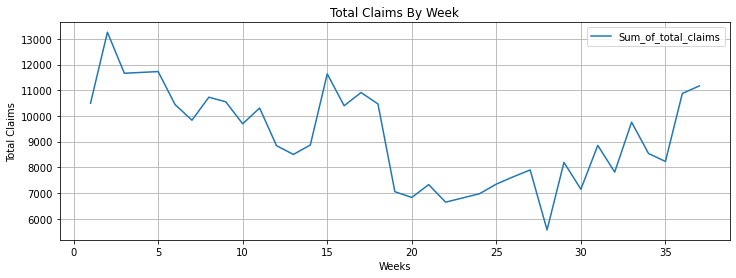

In [26]:
plt.rcParams["figure.figsize"] = (12,4)
ax = Claims_by_week.plot(title='Total Claims By Week').set(ylabel='Total Claims', xlabel='Weeks')
plt.grid(True)

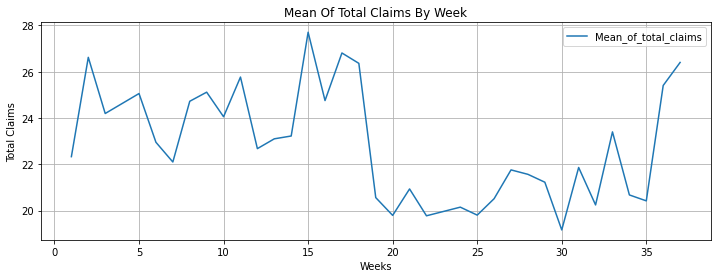

In [27]:
Mean_Claims_by_week = Final_df[['total_claims']].groupby(cleaned_df.week_number).mean().add_prefix('Mean_of_')
plt.rcParams["figure.figsize"] = (12,4)
ax = Mean_Claims_by_week.plot(title='Mean Of Total Claims By Week').set(ylabel='Total Claims', xlabel='Weeks')
plt.grid(True)

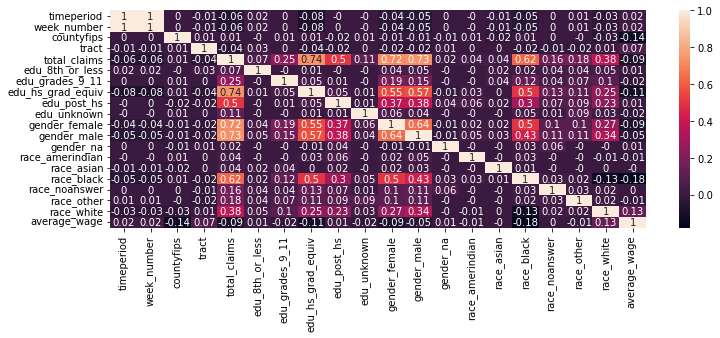

In [28]:
matrix = Final_df.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [29]:
#Top 3 UUID with the max number of claims
Top_10_claimers = Final_df.groupby(['uu_id'])['total_claims'].sum().sort_values(ascending=False)
Top_10_claimers.head(3)

uu_id
c82ff1f157906a6e9c37a08989544676    2454
0ad94f09274e2c9cb0ef5cb77eb334b4    2067
cb304c84e572423d939db1dbb2009609    1758
Name: total_claims, dtype: Int64

In [30]:
#UUIDs with the least number of claims
Top_10_claimers.tail(3)

uu_id
f7f087af0599e6b2eaa4045ba1a0be50    46
747f8bc2b0c8c0a04d29caa4cfe327d2    46
6fbb60a508283bc1fb30c13ac419941a    46
Name: total_claims, dtype: Int64

In [31]:
#Top 3 UUID with the max number of claims
Top_10_claimers = Final_df.groupby(['uu_id'])['total_claims'].sum().sort_values(ascending=False)
Top_10_claimers.head(3)

uu_id
c82ff1f157906a6e9c37a08989544676    2454
0ad94f09274e2c9cb0ef5cb77eb334b4    2067
cb304c84e572423d939db1dbb2009609    1758
Name: total_claims, dtype: Int64

In [32]:
#UUIDs with the least number of claims
Top_10_claimers.tail(3)

uu_id
f7f087af0599e6b2eaa4045ba1a0be50    46
747f8bc2b0c8c0a04d29caa4cfe327d2    46
6fbb60a508283bc1fb30c13ac419941a    46
Name: total_claims, dtype: Int64

In [33]:
#Do people with a certain degree file more claims 
y=[Final_df.edu_8th_or_less.sum(),
   Final_df.edu_grades_9_11.sum(),
   Final_df.edu_hs_grad_equiv.sum(),
   Final_df.edu_post_hs.sum(),
   Final_df.edu_unknown.sum()
  ]

([<matplotlib.axis.YTick at 0x7fee03649ca0>,
 [Text(0, 0, '8th grade or less education'),
  Text(0, 1, '9 through 11'),
  Text(0, 2, 'high school diploma or equivalent'),
  Text(0, 3, 'completed a degree beyond high school'),
  Text(0, 4, 'Education Unknown')])

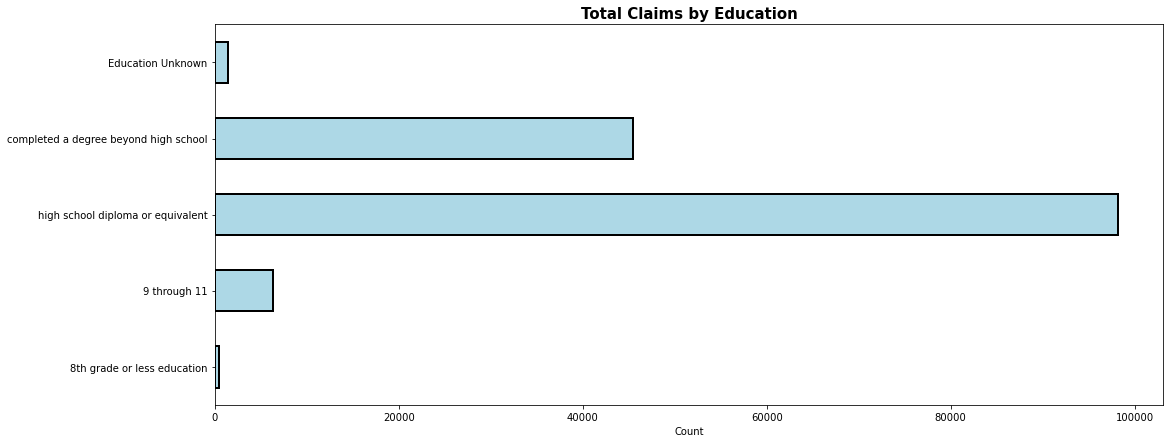

In [34]:
n=len(y)
x = np.arange(n)
plt.subplots(figsize =(17, 7))
plt.title("Total Claims by Education", fontweight ='bold', fontsize = 15)
plt.barh(x,y, height=0.55,color='lightblue', edgecolor='black',linewidth=2)
plt.xlabel('Count')
plt.yticks(x,['8th grade or less education','9 through 11','high school diploma or equivalent','completed a degree beyond high school','Education Unknown'],color='black')

In [35]:
# To display sum values
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.show()

ValueError: Image size of 65747423x909 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x288 with 1 Axes>

In [36]:
#Do people with a certain gender file more claims 
y=[Final_df.gender_female.sum(),
   Final_df.gender_male.sum(),
   Final_df.gender_na.sum()
  ]

([<matplotlib.axis.YTick at 0x7fee123559a0>,
 [Text(0, 0, 'Female'), Text(0, 1, 'Male'), Text(0, 2, 'Gender Unknown')])

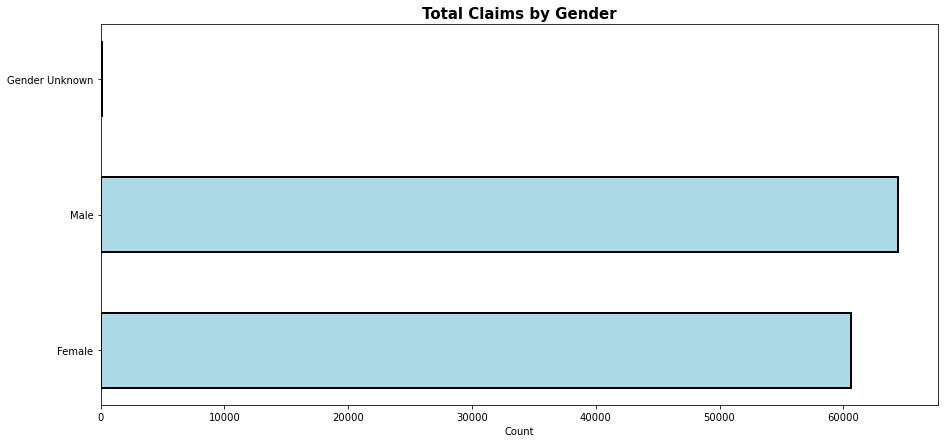

In [37]:
n=len(y)
x = np.arange(n)
plt.subplots(figsize =(15,7))
plt.title("Total Claims by Gender", fontweight ='bold', fontsize = 15)
plt.barh(x,y, height=0.55,color='lightblue', edgecolor='black',linewidth=2)
plt.xlabel('Count')
plt.yticks(x,['Female', 'Male' , 'Gender Unknown'],color='black')

In [38]:
# To display sum values
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.show()

ValueError: Image size of 43115613x474 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x288 with 1 Axes>

In [39]:
#Do people with a certain gender file more claims 
y=[Final_df.race_amerindian.sum(),
   Final_df.race_asian.sum(),
   Final_df.race_black.sum(),
   Final_df.race_noanswer.sum(),
   Final_df.race_other.sum(),
   Final_df.race_white.sum()
  ]

([<matplotlib.axis.YTick at 0x7fee039457f0>,
 [Text(0, 0, 'Amerindian'),
  Text(0, 1, 'Asian'),
  Text(0, 2, 'Black'),
  Text(0, 3, 'No answer'),
  Text(0, 4, 'Other'),
  Text(0, 5, 'White')])

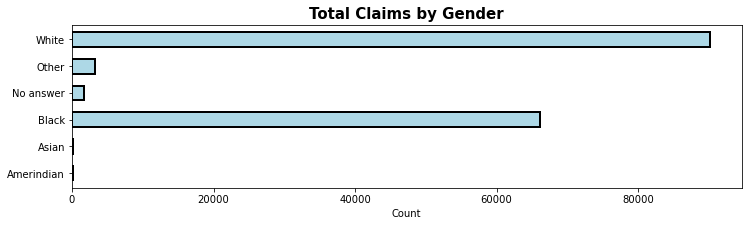

In [40]:
n=len(y)
x = np.arange(n)
plt.subplots(figsize =(12,3))
plt.title("Total Claims by Gender", fontweight ='bold', fontsize = 15)
plt.barh(x,y, height=0.55,color='lightblue', edgecolor='black',linewidth=2)
plt.xlabel('Count')
plt.yticks(x,['Amerindian', 'Asian' , 'Black', 'No answer', 'Other', 'White'],color='black')

In [41]:
# To display sum values
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.show()

ValueError: Image size of 60323663x1126 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x288 with 1 Axes>

In [42]:
pd.set_option('float_format', '{:f}'.format)
Final_df[['average_wage']].describe()

,average_wage
count,13977.000000
mean,11656.941853
std,4135.639055
min,3992.500000
25%,8797.600000
50%,11044.875000
75%,13895.333333
max,41267.000000


In [43]:
Final_df[['top_category_employer1', 'top_category_employer2', 'top_category_employer3']].describe()

,top_category_employer1,top_category_employer2,top_category_employer3
count,13977,13977,13977
unique,21,22,22
top,31-33,56,56
freq,3726,2527,2015


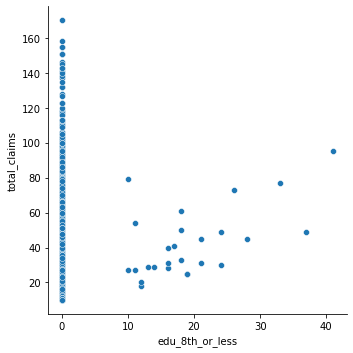

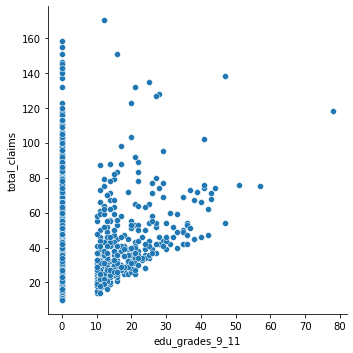

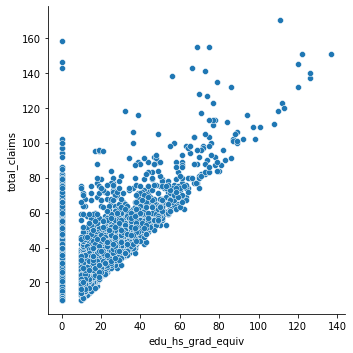

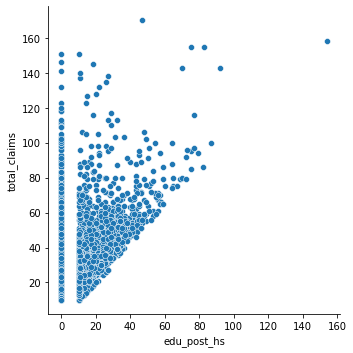

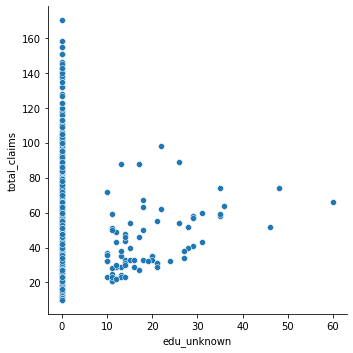

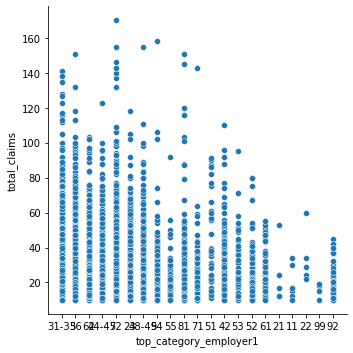

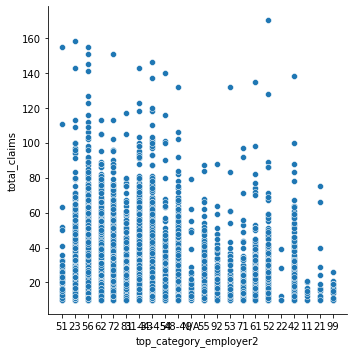

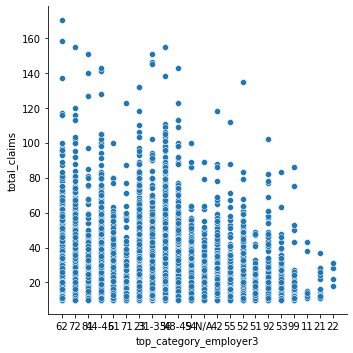

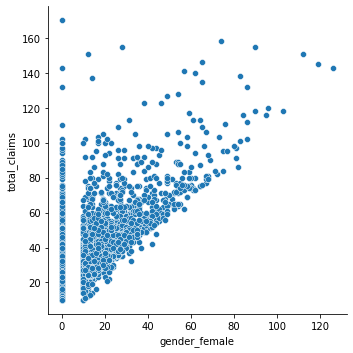

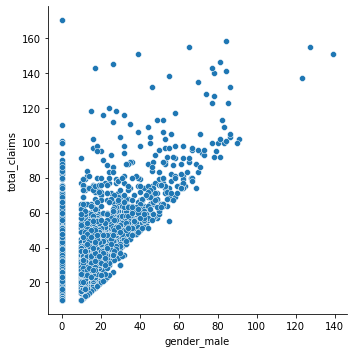

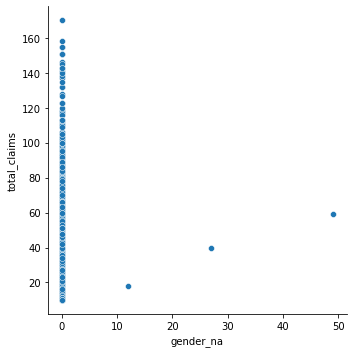

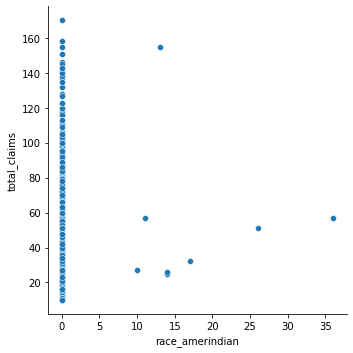

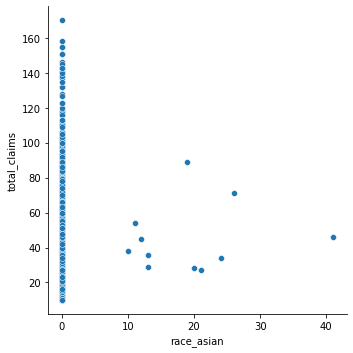

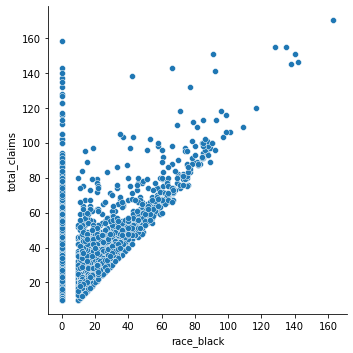

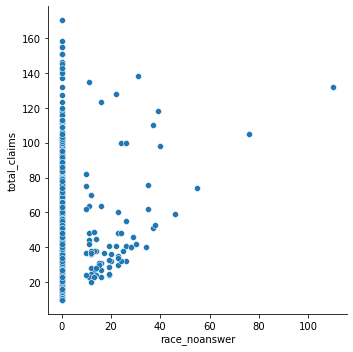

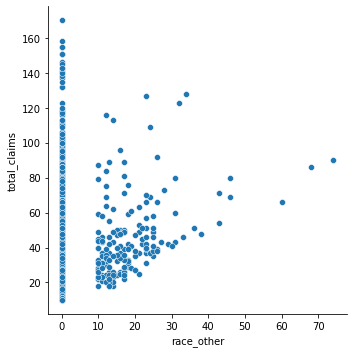

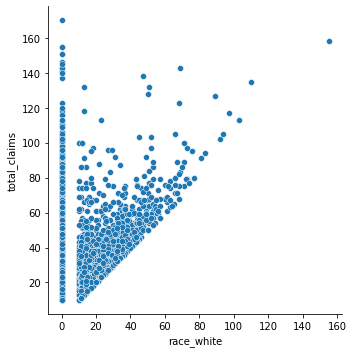

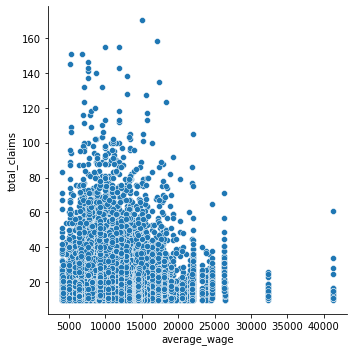

In [44]:
sns.relplot(x ="edu_8th_or_less", y ="total_claims",
            data = Final_df);
sns.relplot(x ="edu_grades_9_11", y ="total_claims",
            data = Final_df);
sns.relplot(x ="edu_hs_grad_equiv", y ="total_claims",
            data = Final_df);
sns.relplot(x ="edu_post_hs", y ="total_claims",
            data = Final_df);
sns.relplot(x ="edu_unknown", y ="total_claims",
            data = Final_df);
sns.relplot(x ="top_category_employer1", y ="total_claims",
            data = Final_df);
sns.relplot(x ="top_category_employer2", y ="total_claims",
            data = Final_df);
sns.relplot(x ="top_category_employer3", y ="total_claims",
            data = Final_df);
sns.relplot(x ="gender_female", y ="total_claims",
            data = Final_df);
sns.relplot(x ="gender_male", y ="total_claims",
            data = Final_df);
sns.relplot(x ="gender_na", y ="total_claims",
            data = Final_df);
sns.relplot(x ="race_amerindian", y ="total_claims",
            data = Final_df);
sns.relplot(x ="race_asian", y ="total_claims",
            data = Final_df);
sns.relplot(x ="race_black", y ="total_claims",
            data = Final_df);
sns.relplot(x ="race_noanswer", y ="total_claims",
            data = Final_df);
sns.relplot(x ="race_other", y ="total_claims",
            data = Final_df);
sns.relplot(x ="race_white", y ="total_claims",
            data = Final_df);
sns.relplot(x ="average_wage", y ="total_claims",
            data = Final_df);

In [45]:
Final_df['timeperiod'] = pd.to_datetime(Final_df['timeperiod'],
                          format='%Y%m%d') 

In [46]:
d = dict.fromkeys(Final_df.select_dtypes(np.int64).columns, np.int32)
Final_df = Final_df.astype(d)
Final_df.dtypes

uu_id                             object
timeperiod                datetime64[ns]
week_number                        int32
countyfips                         int32
tract                              int32
tract_name                        object
total_claims                       int32
edu_8th_or_less                    int32
edu_grades_9_11                    int32
edu_hs_grad_equiv                  int32
edu_post_hs                        int32
edu_unknown                        int32
top_category_employer1            object
top_category_employer2            object
top_category_employer3            object
gender_female                      int32
gender_male                        int32
gender_na                          int32
race_amerindian                    int32
race_asian                         int32
race_black                         int32
race_noanswer                      int32
race_other                         int32
race_white                         int32
average_wage    

In [47]:
Final_df.uu_id.unique()

array(['f013068de98db1470bd986137a0c6d23',
       '21957d5517323845818d87623589e1ba',
       '6a5609f385912113b6f1014b958ed748',
       '46b2882ec4c373527ec33f7bd4f1388d',
       '37495d17e82f7df326bfc2c4c090f7b7',
       '25a57fe39e03c632125308737a7d3769',
       '45c8cf419dd4c4b442dbf3603ba94379',
       '8f782a6153268c6031e31784e2d4eae2',
       '5c04f20bd2f8552aa7ac210dc01292fb',
       '050a624d618a68e43fe31189909c644f',
       'bc7ebe1813e2b66f084289e1b1172f21',
       '6239669cbfe444abd0a46536a670d150',
       '6657c9871fa2f67cd168e6f94354060e',
       '7df3e38fbdab0a32ca0fa9fb6c8bd8c4',
       'e8f426c17a7172179be379cb926bd278',
       '3934b01a1e31d0a6af96867e1afbf03c',
       '5e9480dba0f8de932f4d9fb55fa6b8b1',
       '1bd2241076381b8c9e85d660512a013e',
       '196c37e49c98e0b8cdd142c001431a7a',
       '8ed377ac3767ffda176fcdea40bcd7e4',
       'c06321bd819be6f5c537c67a2797bd12',
       '06e492b4f29d153af26c659d1f7da2a1',
       '53405bf66812a9f2623a307de572c11e',
       'bf9

In [48]:
#Final_df.loc[Merged_unemployment_wage['uu_id'] == 'f013068de98db1470bd986137a0c6d23'].sort_values('week_number')
uuid1 = Final_df[Final_df['uu_id']=='f013068de98db1470bd986137a0c6d23'].sort_values('week_number')
#uuid1['timeperiod'] = pd.to_datetime(uuid1['timeperiod'],
#                          format='%Y%m%d') 
uuid1

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_other,race_white,average_wage
7,f013068de98db1470bd986137a0c6d23,2022-01-01,1,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125000
14,f013068de98db1470bd986137a0c6d23,2022-01-08,2,18003,900,"Census Tract 9, Allen County, Indiana",17,0,0,14,...,0,0,0,0,0,0,0,0,0,8347.125000
13,f013068de98db1470bd986137a0c6d23,2022-01-15,3,18003,900,"Census Tract 9, Allen County, Indiana",20,0,0,0,...,0,0,0,0,0,0,0,0,17,8347.125000
9,f013068de98db1470bd986137a0c6d23,2022-01-29,5,18003,900,"Census Tract 9, Allen County, Indiana",18,0,0,13,...,0,0,0,0,0,0,0,0,15,8347.125000
4,f013068de98db1470bd986137a0c6d23,2022-02-05,6,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125000
1,f013068de98db1470bd986137a0c6d23,2022-02-12,7,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125000
16,f013068de98db1470bd986137a0c6d23,2022-02-26,9,18003,900,"Census Tract 9, Allen County, Indiana",14,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125000
5,f013068de98db1470bd986137a0c6d23,2022-03-05,10,18003,900,"Census Tract 9, Allen County, Indiana",14,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125000
3,f013068de98db1470bd986137a0c6d23,2022-03-12,11,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125000
8,f013068de98db1470bd986137a0c6d23,2022-03-19,12,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125000


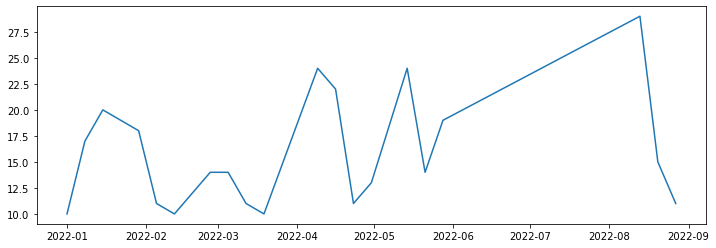

In [49]:
plt.plot(uuid1['timeperiod'], uuid1['total_claims'])
plt.show()

In [50]:
data = uuid1[['timeperiod', 'total_claims']] 
data.dropna(inplace=True)
data.columns = ['ds', 'y'] 
data.head()

,ds,y
7,2022-01-01,10
14,2022-01-08,17
13,2022-01-15,20
9,2022-01-29,18
4,2022-02-05,11


In [51]:
model = m.fit(data, freq='W')

NameError: name 'm' is not defined

In [52]:
m = NeuralProphet()

In [53]:
get_ipython().system('pip install db-dtypes')

In [54]:
get_ipython().system('pip install neuralprophet')

In [55]:
#LIBRARIES
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import warnings 
warnings.filterwarnings('ignore')
from scipy import stats  
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [56]:
from neuralprophet import NeuralProphet
import pickle

In [57]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [58]:
m = NeuralProphet()

In [59]:
model = m.fit(data, freq='W')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 70.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000
WARNING - (NP.config.set_lr_fin

Epoch 1000: 100%|██████████| 1000/1000 [00:00<00:00, 110353.19it/s, loss=0.0486, v_num=0, MAE=4.430, RMSE=5.300, Loss=0.0603, RegLoss=0.000] 


In [60]:
future = m.make_future_dataframe(data, periods=20)
forecast = m.predict(future)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 70.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 95.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 95.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.37it/s]


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend
0,2022-08-28,None,17.053030,17.053030
1,2022-09-04,None,16.555170,16.555170
2,2022-09-11,None,16.057308,16.057308
3,2022-09-18,None,15.559450,15.559450
4,2022-09-25,None,15.061592,15.061592
5,2022-10-02,None,14.563730,14.563730
6,2022-10-09,None,14.065871,14.065871
7,2022-10-16,None,13.568010,13.568010
8,2022-10-23,None,13.070152,13.070152
9,2022-10-30,None,12.572293,12.572293


In [61]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [62]:
get_ipython().system('pip install db-dtypes')

In [63]:
get_ipython().system('pip install neuralprophet')

In [64]:
#LIBRARIES
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import warnings 
warnings.filterwarnings('ignore')
from scipy import stats  
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [65]:
from neuralprophet import NeuralProphet
import pickle

In [66]:
get_ipython().system('pip install db-dtypes')

In [67]:
get_ipython().system('pip install neuralprophet')